In [68]:
import json
import matplotlib.pyplot as plt
import numpy as np

import sys  
sys.path.insert(1, 'funcs')
import ScalarField
import TangentPoint
import TangentPointSet
from sklearn.cluster import DBSCAN

In [69]:
f = open("tangentmaps/breast_cancer.tmap","r")
dataImport = json.loads(f.read())
tmap = dataImport['tmap']
Col_labels = dataImport['Col_labels']

data = dataImport

# print(data['tmap'][0])
# print(data['Col_labels'])

In [70]:
# First pass: Create Point instances with any initial scale_factor (e.g., 1.0)
points = []
for tmap_entry in tmap:
    point = TangentPoint.TangentPoint(tmap_entry, 1.0, Col_labels)
    points.append(point)

# Collect all gradient vectors and positions from the Point instances
all_positions = np.array([point.position for point in points if point.valid])  # Shape: (M, 2)
all_gradient_vectors = np.vstack([point.gradient_vectors for point in points if point.valid])  # Shape: (total_num_vectors, 2)

# Compute maximum gradient vector length
gradient_lengths = np.linalg.norm(all_gradient_vectors, axis=1)
max_gradient_length = np.max(gradient_lengths)

# Compute position ranges
x_range = np.max(all_positions[:, 0]) - np.min(all_positions[:, 0])
y_range = np.max(all_positions[:, 1]) - np.min(all_positions[:, 1])
position_range = max(x_range, y_range)

# Decide on desired fraction of position range for maximum gradient length
desired_fraction = 0.05  # Adjust as necessary

# Compute scale factor
scale_factor = (position_range * desired_fraction) / max_gradient_length
print("Computed scale factor:", scale_factor)

# Update scale factor in each Point instance
for point in points:
    if point.valid:
        point.update_scale_factor(scale_factor)

Computed scale factor: 0.6178953731105454


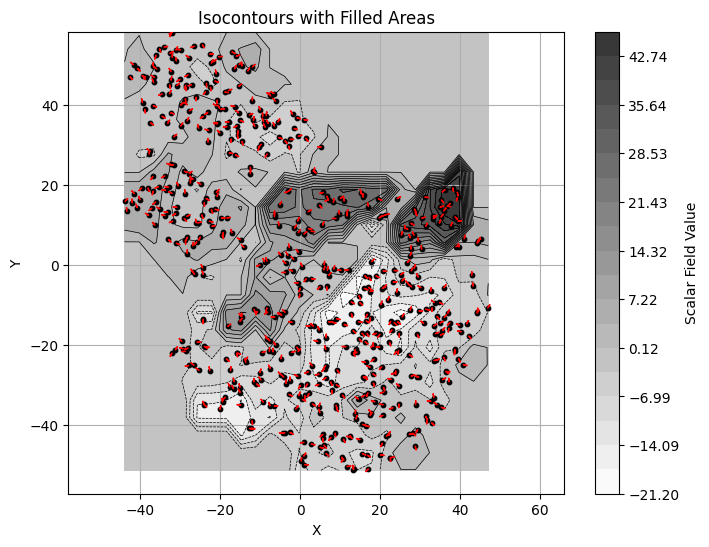

In [71]:
# Call the function with the points
feature_idx = 1
f_grid, X_grid, Y_grid, contour_levels = ScalarField.reconstruct_scalar_field(points, grid_size=25, feature_index=feature_idx)

fig, ax = plt.subplots(figsize=(8, 6))

# Create a colormap
cmap = plt.get_cmap('binary')

# Plot filled contours
contourf = ax.contourf(X_grid, Y_grid, f_grid, levels=contour_levels, cmap=cmap, alpha=0.8)

# Plot contour lines on top
contours = ax.contour(X_grid, Y_grid, f_grid, levels=contour_levels, colors='k', linewidths=0.5)

# Add a colorbar
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label('Scalar Field Value')

# Plot the point positions
positions = np.array([point.position for point in points if point.valid])
ax.scatter(positions[:, 0], positions[:, 1], c='black', s=10, zorder=5)

# Optionally plot the gradient vectors
for point in points:
    if point.valid:
        x, y = point.position
        # Using the same selected gradient as in the function
        gradients = point.gradient_vectors
        magnitudes = np.linalg.norm(gradients, axis=1)
        max_idx = np.argmax(magnitudes)
        gi = gradients[feature_idx]
        gi_norm = np.linalg.norm(gi)
        if gi_norm != 0:
            gi_unit = gi / gi_norm
        else:
            gi_unit = gi
        arrow_scale = 1
        ax.arrow(
            x, y,
            gi_unit[0] * arrow_scale, gi_unit[1] * arrow_scale,
            head_width=0.1,
            head_length=0.1,
            fc='red',
            ec='red',
            length_includes_head=True,
            zorder=6
        )

ax.set_title('Isocontours with Filled Areas')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.axis('equal')
plt.grid(True)
plt.show()

# Feature Wind

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter

In [73]:
feature_count = len(Col_labels)
all_colors = plt.cm.tab10(np.linspace(0, 1, feature_count))  # Colors for all features

grid_size = 25

In [74]:
# --- Select by top features ---
# n = 3  # Number of top features to select
# feature_max_vals = []

# # Compute maximum value for each feature
# for feature_idx in range(feature_count):
#     f_grid_feature, _, _, _ = ScalarField.reconstruct_scalar_field(points, grid_size=grid_size, feature_index=feature_idx)
#     max_val = np.nanmax(f_grid_feature)
#     feature_max_vals.append(max_val)

# # Get indices of top n features with highest max values.
# top_n_indices = np.argsort(feature_max_vals)[::-1][:n]

# # select feature by indices
# selected_features = top_n_indices.tolist()

# --- Selected by indices ---
selected_features = [1]

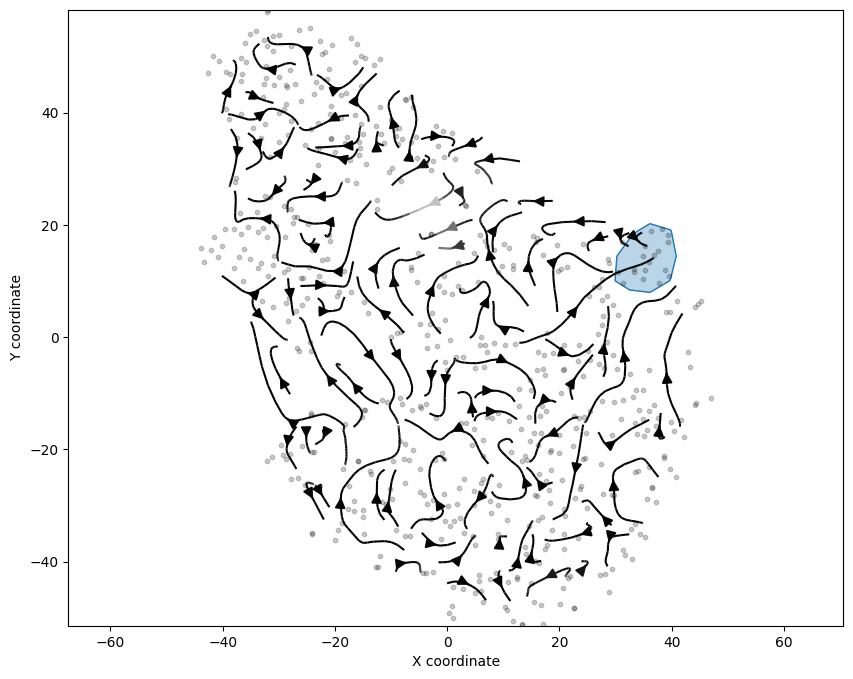

In [75]:
selected_colors = all_colors[selected_features]

fig, ax = plt.subplots(figsize=(10, 8))

# Use one of the selected features to set the grid reference.
f_grid, X_grid, Y_grid, contour_levels = ScalarField.reconstruct_scalar_field(
    points, grid_size=grid_size, feature_index=selected_features[0]
)

for i, feature_idx in enumerate(selected_features):
    # Reconstruct the scalar field for the current feature.
    f_grid_feature, _, _, _ = ScalarField.reconstruct_scalar_field(
        points, grid_size=grid_size, feature_index=feature_idx
    )

    f_grid_feature = gaussian_filter(f_grid_feature, sigma=1)  # Adjust sigma
    
    # Define threshold near the maximum value.
    max_val = np.nanmax(f_grid_feature)
    min_val = np.nanmin(f_grid_feature)
    tolerance = 0.05 * (max_val - min_val)  # adjust tolerance as desired
    threshold = max_val - tolerance

    threshold = np.nanpercentile(f_grid_feature, 99)  # Top 5% of values
    
    # Plot filled contour for regions with high values for the current feature.
    ax.contourf(
        X_grid, Y_grid, f_grid_feature,
        levels=[threshold, max_val],
        colors=[selected_colors[i]],
        alpha=0.3, zorder=feature_idx
    )
    
    # Optionally display contour lines for the maximum region.
    ax.contour(
        X_grid, Y_grid, f_grid_feature,
        levels=[threshold, max_val],
        colors=[selected_colors[i]], linewidths=1
    )
    
    # # Add label to this contour.
    # mask = f_grid_feature >= threshold
    # if np.any(mask):
    #     label_x = np.median(X_grid[mask])
    #     label_y = np.median(Y_grid[mask])
    #     ax.text(label_x, label_y, Col_labels[feature_idx],
    #             color='black', fontsize=10, ha='center', va='center',
    #             zorder=feature_idx+1)

# Plot the underlying point positions for reference.
positions = np.array([point.position for point in points if point.valid])
ax.scatter(positions[:, 0], positions[:, 1], c='black', s=10, zorder=20, alpha=0.2)

# Add a legend for the selected features.
gradient_list = np.array([
    np.mean([point.gradient_vectors[i] for i in selected_features], axis=0)
    for point in points if point.valid
])

# Normalize each gradient vector.
norms = np.linalg.norm(gradient_list, axis=1)
norms[norms == 0] = 1  # Avoid division by zero.
gradient_list_normalized = gradient_list / norms[:, None]

# Interpolate the gradient vectors onto the scalar field grid (X_grid, Y_grid).
grid_gx = griddata((positions[:, 0], positions[:, 1]), gradient_list[:, 0], (X_grid, Y_grid), method='cubic')
grid_gy = griddata((positions[:, 0], positions[:, 1]), gradient_list[:, 1], (X_grid, Y_grid), method='cubic')

# Smooth the interpolated gradient vectors for a more organized flow field.
smooth_sigma = 0.1
grid_gx_smooth = gaussian_filter(grid_gx, sigma=smooth_sigma)
grid_gy_smooth = gaussian_filter(grid_gy, sigma=smooth_sigma)

# Compute the magnitude and normalize it.
hyp = np.hypot(grid_gx, grid_gy)

# feature wind
strm = ax.streamplot(
    X_grid,
    Y_grid,
    grid_gx_smooth,
    grid_gy_smooth,
    density=1,         # Increase density for more streamlines
    color=hyp,         # Color by magnitude
    cmap='gray',
    arrowsize=1.5,     # Adjust arrow size as needed
    # arrowstyle='->',   # Use arrows for a wind-like effect
    zorder=10
)

ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.axis('equal')
plt.grid(False)
plt.show()

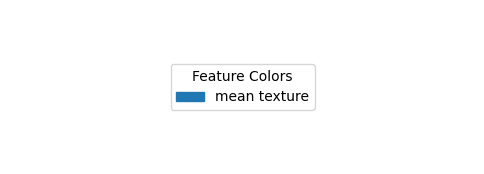

In [76]:
import matplotlib.patches as mpatches

plt.show()

# Create a separate figure for the legend (color-label relationship)
fig_legend, ax_legend = plt.subplots(figsize=(6, 2))
ax_legend.axis('off')  # Hide the axis

# Build legend handles using the selected colors and feature indices.
legend_handles = [
    mpatches.Patch(color=selected_colors[i], label=Col_labels[selected_features[i]])
    for i in range(len(selected_features))
]
ncol = 6 if len(selected_features) > 6 else len(selected_features)
ax_legend.legend(handles=legend_handles, loc='center', ncol=ncol, title="Feature Colors")

plt.show()

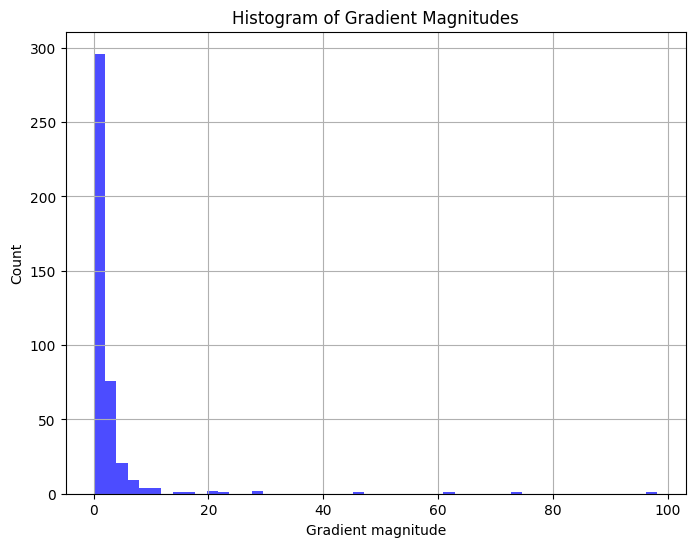

In [77]:
# Plot a histogram of the hyp array values.
plt.figure(figsize=(8,6))
plt.hist(hyp.flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Gradient Magnitudes")
plt.xlabel("Gradient magnitude")
plt.ylabel("Count")
plt.grid(True)
plt.show()